# Continuación Logistic Regression con K-fold Cross Validation

La [**Validación cruzada**](https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f) (cross validation) es un conjunto de técnicas para evaluar la eficacia de los resultados de un modelo en un conjunto de datos fuera de la muestra, es decir, en la práctica o en la producción. Se utiliza principalmente para detectar el overfitting.

La validación cruzada funciona de la siguiente manera: se dividen los datos disponibles en $k$ conjuntos, o **pliegues**. Se utilizarán $k - 1$ de estos pliegues para entrenar el modelo, mientras que el pliegue retenido se utilizará como conjunto de prueba en el que se evalúa el modelo. Para la estabilidad computacional, este procedimiento se suele dividir muchas veces, de manera que cada pliegue tenga la oportunidad de servir como conjunto de prueba. Para cada repetición, se calcula una métrica de rendimiento de la predicción (por ejemplo, AUC) en el conjunto de prueba. A continuación, se presenta la media de estas métricas, así como su desviación estándar. 

No existe una ciencia exacta para elegir un $k$ adecuado para su conjunto de datos. Depende del tipo de datos que se utilice y de su tamaño. Cuanto más grande sea $k$, más iteraciones se realizan, lo que reduce la posibilidad de tener "mala suerte"; sin embargo, realizar más iteraciones puede ser costoso en algunos casos. Además, es importante asegurarse de que, independientemente de la cantidad de $k$ que se elija, el conjunto de validación sea lo suficientemente grande como para que tenga sentido. Si tiene un conjunto de datos de 100 puntos y elige un $k$ de 20, entonces el conjunto de validación será sólo de 5 puntos. Es probable que algunas iteraciones tengan un mal rendimiento simplemente porque el conjunto de validación es demasiado pequeño y potencialmente demasiado diferente del conjunto de entrenamiento.

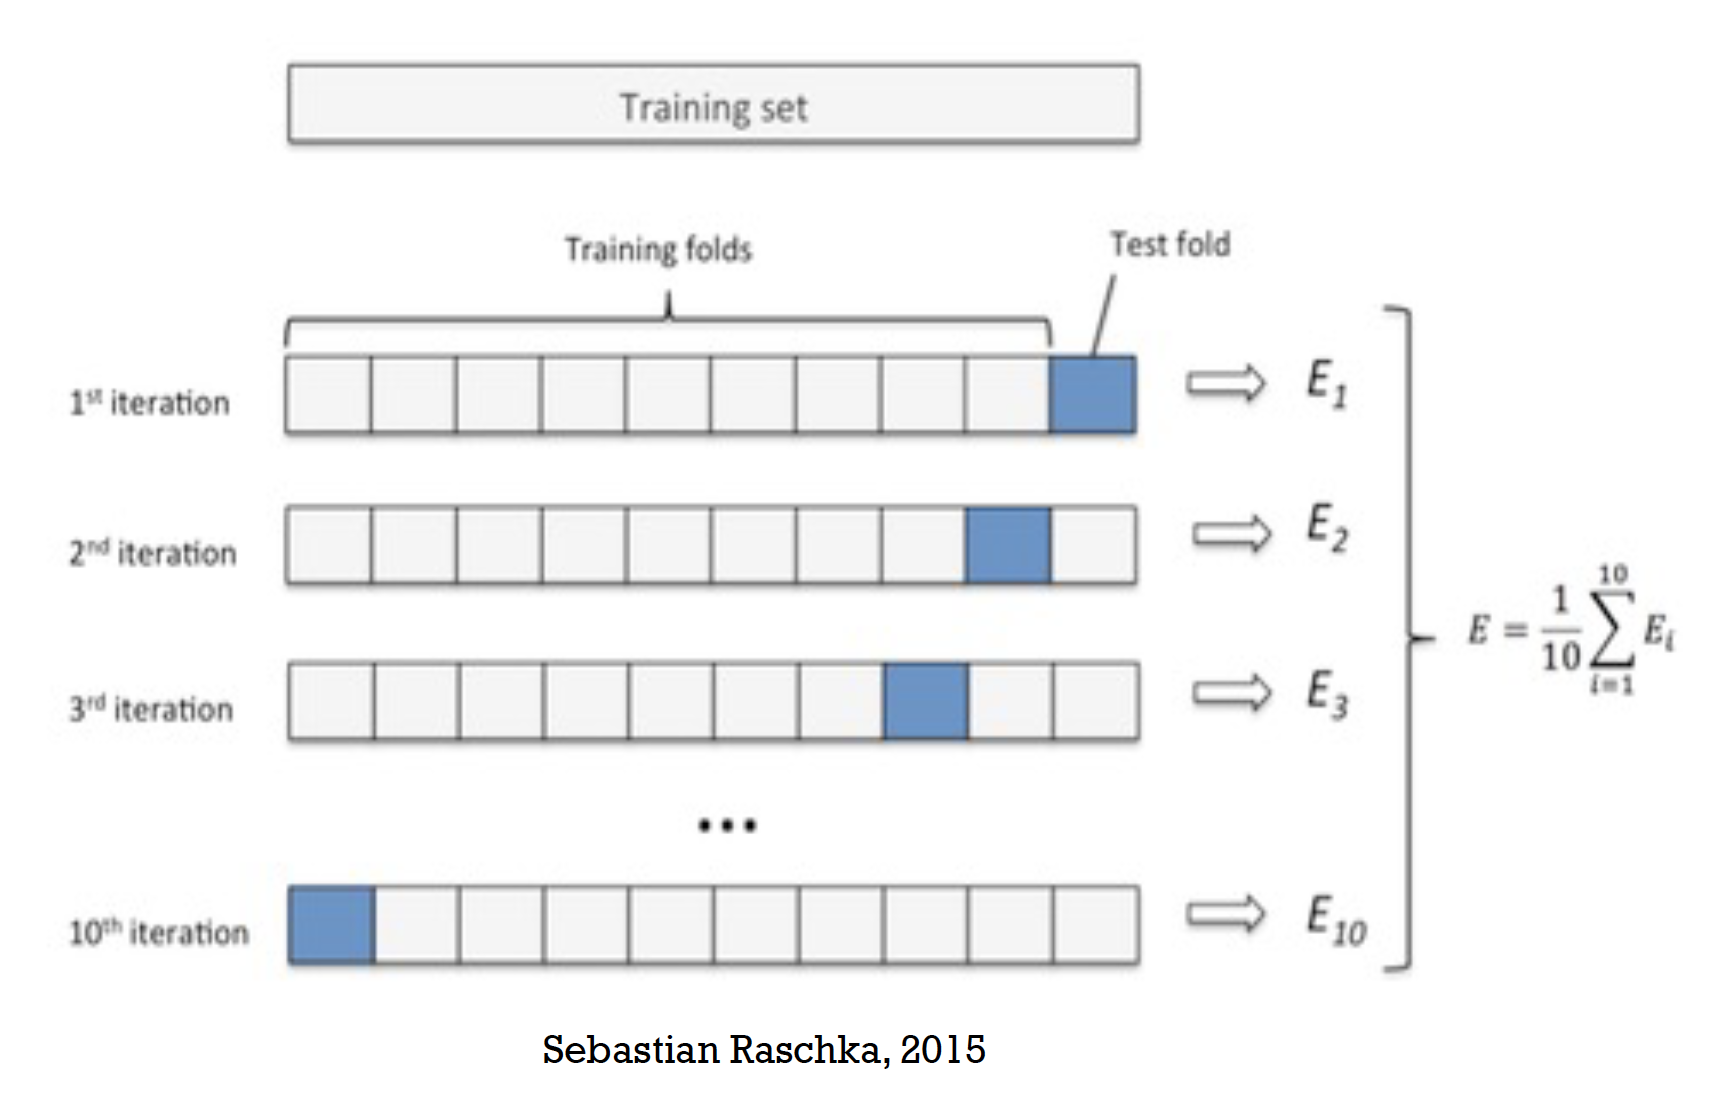

## Ejercicios

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

Cargamos los datos loan_light.csv que previamente habíamos trabajado (Logistic Regression)

In [77]:
data=pd.read_csv("loan_light.csv")

In [78]:
data.head()

,annual_inc,application_type,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,grade,inq_last_12m,installment,...,num_actv_bc_tl,pub_rec_bankruptcies,home_ownership,term,mort_acc,num_tl_90g_dpd_24m,purpose,year,loan_default,job
0,80000.0,Individual,6746.0,0.0,0.0,15.12,10,B,1.0,743.75,...,1.0,0.0,OWN,36,0.0,0.0,debt_consolidation,2016,1,principal
1,60000.0,Individual,13623.0,0.0,0.0,12.32,7,D,0.0,286.73,...,3.0,0.0,MORTGAGE,60,1.0,0.0,credit_card,2017,0,other
2,78000.0,Individual,11011.0,0.0,0.0,25.00,1,D,6.0,869.66,...,4.0,0.0,MORTGAGE,60,3.0,0.0,debt_consolidation,2015,0,analyst
3,62000.0,Individual,9679.0,0.0,0.0,22.32,9,D,7.0,713.96,...,2.0,0.0,RENT,36,4.0,0.0,debt_consolidation,2017,1,other
4,49000.0,Individual,4925.0,0.0,0.0,32.43,10,D,0.0,366.51,...,4.0,0.0,RENT,36,0.0,0.0,debt_consolidation,2017,1,driver


El siguiente código define una función compute_AUC(X, y, train_index, test_index) que calcula el AUC de un modelo entrenado en "train_index" y probado en "test_index". (ejecutar celda)

In [79]:
def compute_AUC(X, y, train_index, test_index):
    """
    feature/output: X, y
    dataset split: train_index, test_index
    """
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    clf = LogisticRegression(solver='lbfgs', tol=10**-4,  
                             fit_intercept=True, 
                             multi_class='multinomial').fit(X_train, y_train)
    default_proba_test = clf.predict_proba(X_test)[:,1]  
    fpr, tpr, _ = roc_curve(y_test, default_proba_test)
    auc_score = auc(fpr, tpr)
    return auc_score, fpr, tpr

cross_validation_AUC(X,y,nfold) realiza una validación cruzada de k veces y devuelve una lista que contiene el área bajo la curva para cada pliegue de la validación cruzada. (ejecutar celda)

In [80]:
def cross_validation_AUC(X,y, k):
    """
    use a n-fold cross-validation for computing AUC estimates
    """
    skf = StratifiedKFold(n_splits=k)  #create a cross-validation splitting
    auc_list = [] #this list will contain the AUC estimates associated with each fold
    for k, (train_index, test_index) in enumerate( skf.split(X, y) ):
        auc_score, _, _ = compute_AUC(X, y, train_index, test_index)
        auc_list.append(auc_score)
    return auc_list

A continuación, Creamos un DataFrame data_numeric con solo las variables numérias (incluyendo nuestra variable objetivo 'loan_default')

In [81]:
data_numeric=data.select_dtypes(include=np.number)

In [82]:
data_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   annual_inc                5000 non-null   float64
 1   avg_cur_bal               5000 non-null   float64
 2   chargeoff_within_12_mths  5000 non-null   float64
 3   delinq_2yrs               5000 non-null   float64
 4   dti                       5000 non-null   float64
 5   emp_length                5000 non-null   int64  
 6   inq_last_12m              5000 non-null   float64
 7   installment               5000 non-null   float64
 8   loan_amnt                 5000 non-null   int64  
 9   num_actv_bc_tl            5000 non-null   float64
 10  pub_rec_bankruptcies      5000 non-null   float64
 11  term                      5000 non-null   int64  
 12  mort_acc                  5000 non-null   float64
 13  num_tl_90g_dpd_24m        5000 non-null   float64
 14  year    

Luego creamos un dataframe "model_perf" donde guardaremos el performance de nuestros modelos (AUC). Comenzamos entrenando el modelo (simple) con solo 1 variable de forma iterativa con k = 10, para cada una de ellas

In [83]:
model_perf = pd.DataFrame({}) #this data-frame will contain the AUC estimates
for key in data_numeric.keys():
    if key == "loan_default": continue
    X_full, y_full = data_numeric[[key]], data_numeric.loan_default
    auc_list = cross_validation_AUC(X_full, y_full, k=10)
    model_perf["SIMPLE:" + key] = auc_list

In [84]:
model_perf

,SIMPLE:annual_inc,SIMPLE:avg_cur_bal,SIMPLE:chargeoff_within_12_mths,SIMPLE:delinq_2yrs,SIMPLE:dti,SIMPLE:emp_length,SIMPLE:inq_last_12m,SIMPLE:installment,SIMPLE:loan_amnt,SIMPLE:num_actv_bc_tl,SIMPLE:pub_rec_bankruptcies,SIMPLE:term,SIMPLE:mort_acc,SIMPLE:num_tl_90g_dpd_24m,SIMPLE:year
0,0.598588,0.553134,0.499548,0.494003,0.560858,0.504709,0.522417,0.539153,0.529328,0.497019,0.479752,0.538340,0.525771,0.499537,0.508458
1,0.504449,0.516443,0.498250,0.477470,0.492084,0.537787,0.546765,0.548933,0.560339,0.478667,0.472219,0.619085,0.556375,0.498792,0.517414
2,0.548696,0.574308,0.491304,0.488312,0.601852,0.500553,0.595415,0.583173,0.572897,0.608131,0.495901,0.583060,0.561016,0.515754,0.491745
3,0.514466,0.528154,0.498250,0.462981,0.606674,0.478554,0.562586,0.585545,0.577787,0.595121,0.503320,0.556973,0.528571,0.475901,0.553326
4,0.550503,0.532739,0.506494,0.515584,0.580892,0.500655,0.530649,0.542462,0.538250,0.542360,0.501615,0.562225,0.567261,0.481378,0.545127
5,0.552287,0.550661,0.495200,0.474602,0.583331,0.531135,0.552524,0.597335,0.595494,0.513676,0.503715,0.590006,0.577053,0.491880,0.500011
6,0.580632,0.582947,0.492208,0.498905,0.592513,0.518679,0.556341,0.574896,0.568255,0.501649,0.489294,0.564314,0.582484,0.502891,0.501909
7,0.613876,0.565165,0.502113,0.463322,0.587606,0.543553,0.553404,0.482547,0.510170,0.455777,0.479956,0.566130,0.597707,0.484456,0.555325
8,0.529975,0.512669,0.502591,0.499216,0.585208,0.512328,0.506658,0.601241,0.599832,0.518578,0.499011,0.585969,0.535292,0.502522,0.483115
9,0.589310,0.612967,0.499023,0.503341,0.548427,0.514851,0.535395,0.581913,0.574414,0.542201,0.486706,0.548382,0.586049,0.485342,0.545360


1. En un solo diagrama de cajas y bigotes, grafique la tabla model_perf. (donde el eje 'x' sean las columnas y el 'y' las filas). Pista: puede usar el metodo melt de pandas

In [85]:
df = pd.melt(model_perf)
df

,variable,value
0,SIMPLE:annual_inc,0.598588
1,SIMPLE:annual_inc,0.504449
2,SIMPLE:annual_inc,0.548696
3,SIMPLE:annual_inc,0.514466
4,SIMPLE:annual_inc,0.550503
...,...,...
145,SIMPLE:year,0.500011
146,SIMPLE:year,0.501909
147,SIMPLE:year,0.555325
148,SIMPLE:year,0.483115


[Text(0, 0, 'SIMPLE:annual_inc'),
 Text(1, 0, 'SIMPLE:avg_cur_bal'),
 Text(2, 0, 'SIMPLE:chargeoff_within_12_mths'),
 Text(3, 0, 'SIMPLE:delinq_2yrs'),
 Text(4, 0, 'SIMPLE:dti'),
 Text(5, 0, 'SIMPLE:emp_length'),
 Text(6, 0, 'SIMPLE:inq_last_12m'),
 Text(7, 0, 'SIMPLE:installment'),
 Text(8, 0, 'SIMPLE:loan_amnt'),
 Text(9, 0, 'SIMPLE:num_actv_bc_tl'),
 Text(10, 0, 'SIMPLE:pub_rec_bankruptcies'),
 Text(11, 0, 'SIMPLE:term'),
 Text(12, 0, 'SIMPLE:mort_acc'),
 Text(13, 0, 'SIMPLE:num_tl_90g_dpd_24m'),
 Text(14, 0, 'SIMPLE:year')]

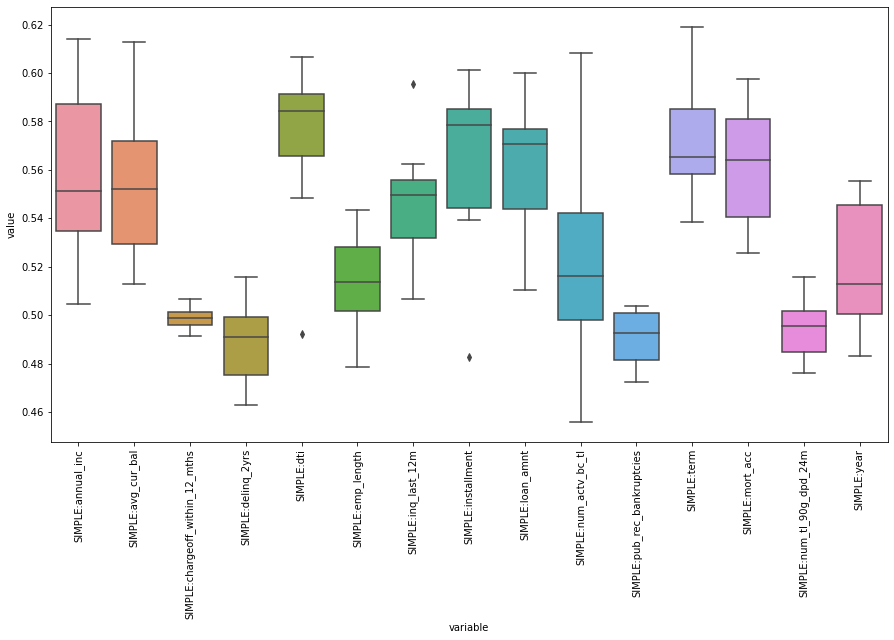

In [86]:
plt.figure(figsize=(15,8))
graf_caja = sns.boxplot(data = df, x = 'variable', y = 'value')
graf_caja.set_xticklabels(graf_caja.get_xticklabels(),rotation = 90)

2. Ahora entrene un modelo con K=10 pero incluyendo TODAS las variables numericas, llamelo allnumeric. Agregue una nueva columna al dataframe model_perf ´allnumeric´. Genere un diagrama de cajas y bigotes 

In [87]:
#pista
#model_perf[allnumeric]=cross_validation_AUC(x,y,k=10)
allnumeric = data._get_numeric_data()
y = allnumeric['loan_default']
allnumeric = allnumeric.drop('loan_default', axis=1)

In [88]:
model_perf2 = model_perf.copy()

In [89]:
model_perf2['allnumeric']=cross_validation_AUC(allnumeric,y,k=10)

A:\Programar\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
A:\Programar\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [90]:
model_perf2

,SIMPLE:annual_inc,SIMPLE:avg_cur_bal,SIMPLE:chargeoff_within_12_mths,SIMPLE:delinq_2yrs,SIMPLE:dti,SIMPLE:emp_length,SIMPLE:inq_last_12m,SIMPLE:installment,SIMPLE:loan_amnt,SIMPLE:num_actv_bc_tl,SIMPLE:pub_rec_bankruptcies,SIMPLE:term,SIMPLE:mort_acc,SIMPLE:num_tl_90g_dpd_24m,SIMPLE:year,allnumeric
0,0.598588,0.553134,0.499548,0.494003,0.560858,0.504709,0.522417,0.539153,0.529328,0.497019,0.479752,0.538340,0.525771,0.499537,0.508458,0.626426
1,0.504449,0.516443,0.498250,0.477470,0.492084,0.537787,0.546765,0.548933,0.560339,0.478667,0.472219,0.619085,0.556375,0.498792,0.517414,0.622722
2,0.548696,0.574308,0.491304,0.488312,0.601852,0.500553,0.595415,0.583173,0.572897,0.608131,0.495901,0.583060,0.561016,0.515754,0.491745,0.691519
3,0.514466,0.528154,0.498250,0.462981,0.606674,0.478554,0.562586,0.585545,0.577787,0.595121,0.503320,0.556973,0.528571,0.475901,0.553326,0.684901
4,0.550503,0.532739,0.506494,0.515584,0.580892,0.500655,0.530649,0.542462,0.538250,0.542360,0.501615,0.562225,0.567261,0.481378,0.545127,0.649170
5,0.552287,0.550661,0.495200,0.474602,0.583331,0.531135,0.552524,0.597335,0.595494,0.513676,0.503715,0.590006,0.577053,0.491880,0.500011,0.699289
6,0.580632,0.582947,0.492208,0.498905,0.592513,0.518679,0.556341,0.574896,0.568255,0.501649,0.489294,0.564314,0.582484,0.502891,0.501909,0.714557
7,0.613876,0.565165,0.502113,0.463322,0.587606,0.543553,0.553404,0.482547,0.510170,0.455777,0.479956,0.566130,0.597707,0.484456,0.555325,0.639692
8,0.529975,0.512669,0.502591,0.499216,0.585208,0.512328,0.506658,0.601241,0.599832,0.518578,0.499011,0.585969,0.535292,0.502522,0.483115,0.668326
9,0.589310,0.612967,0.499023,0.503341,0.548427,0.514851,0.535395,0.581913,0.574414,0.542201,0.486706,0.548382,0.586049,0.485342,0.545360,0.688233


In [91]:
df2 = pd.melt(model_perf2)
df2.head()

,variable,value
0,SIMPLE:annual_inc,0.598588
1,SIMPLE:annual_inc,0.504449
2,SIMPLE:annual_inc,0.548696
3,SIMPLE:annual_inc,0.514466
4,SIMPLE:annual_inc,0.550503


[Text(0, 0, 'SIMPLE:annual_inc'),
 Text(1, 0, 'SIMPLE:avg_cur_bal'),
 Text(2, 0, 'SIMPLE:chargeoff_within_12_mths'),
 Text(3, 0, 'SIMPLE:delinq_2yrs'),
 Text(4, 0, 'SIMPLE:dti'),
 Text(5, 0, 'SIMPLE:emp_length'),
 Text(6, 0, 'SIMPLE:inq_last_12m'),
 Text(7, 0, 'SIMPLE:installment'),
 Text(8, 0, 'SIMPLE:loan_amnt'),
 Text(9, 0, 'SIMPLE:num_actv_bc_tl'),
 Text(10, 0, 'SIMPLE:pub_rec_bankruptcies'),
 Text(11, 0, 'SIMPLE:term'),
 Text(12, 0, 'SIMPLE:mort_acc'),
 Text(13, 0, 'SIMPLE:num_tl_90g_dpd_24m'),
 Text(14, 0, 'SIMPLE:year'),
 Text(15, 0, 'allnumeric')]

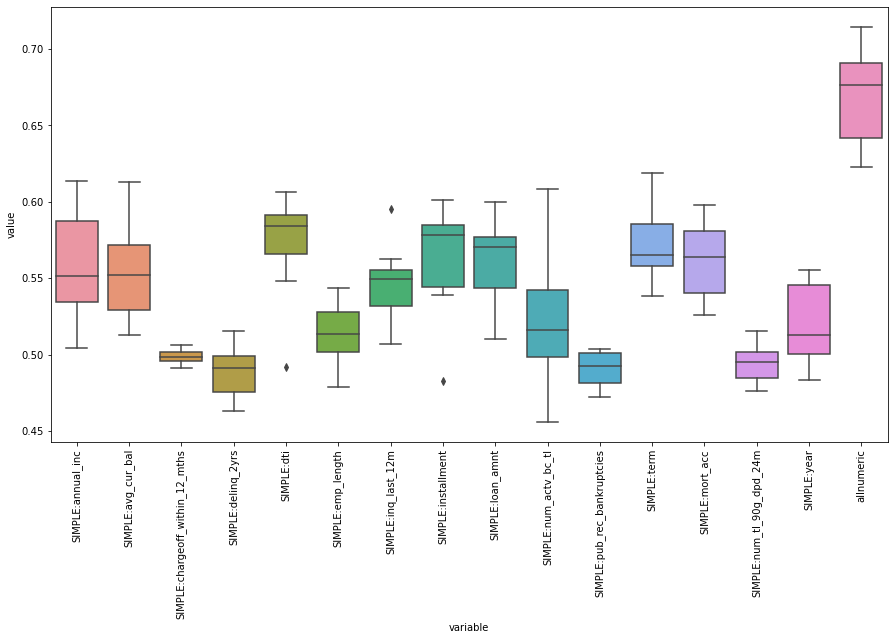

In [92]:
plt.figure(figsize=(15,8))
graf_caja2 = sns.boxplot(data = df2, x = 'variable', y = 'value')
graf_caja2.set_xticklabels(graf_caja2.get_xticklabels(),rotation = 90)

3. Compare el modelo allnumeric con el mejor de las variables simples. Cual es mejor? Grafiquelos en un diagrama de cajas y bigotes

In [93]:
dti = model_perf2['SIMPLE:dti']
allnumeric1 = model_perf2['allnumeric']
df3 = pd.concat([dti, allnumeric1], axis = 1)
df3 = pd.melt(df3)
df3

,variable,value
0,SIMPLE:dti,0.560858
1,SIMPLE:dti,0.492084
2,SIMPLE:dti,0.601852
3,SIMPLE:dti,0.606674
4,SIMPLE:dti,0.580892
5,SIMPLE:dti,0.583331
6,SIMPLE:dti,0.592513
7,SIMPLE:dti,0.587606
8,SIMPLE:dti,0.585208
9,SIMPLE:dti,0.548427


[Text(0, 0, 'SIMPLE:dti'), Text(1, 0, 'allnumeric')]

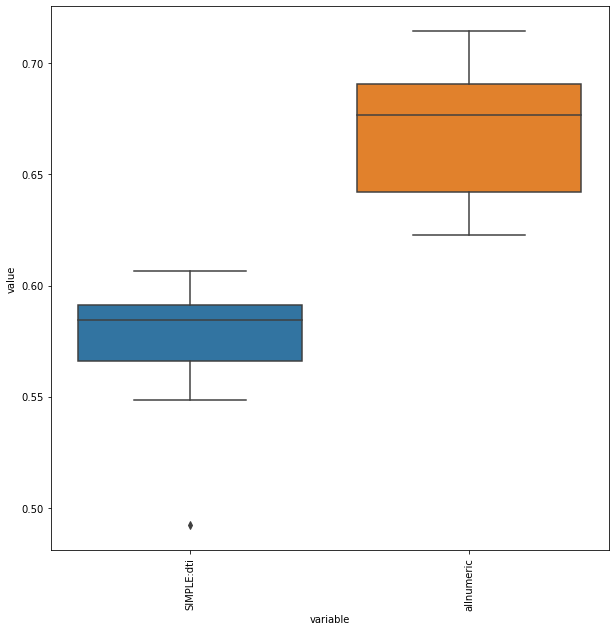

In [94]:
plt.figure(figsize=(10,10))
graf_caja2 = sns.boxplot(data = df3, x = 'variable', y = 'value')
graf_caja2.set_xticklabels(graf_caja2.get_xticklabels(),rotation = 90)

4. Usando pandas.get_dummies(), agregue la variable "grade" al modelo con todas las variables numericas (allnumeric). Cree una nueva columna 'all+grade' en model_perf para guardar el performance. Entrene con K=10 y grafique en un diagrama de cajas y bigotes. Mejora el modelo agregando la variable grade?

In [95]:
grade = data['grade']
data_dummies = pd.concat([allnumeric, grade], axis = 1)
data_dummies

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,installment,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,term,mort_acc,num_tl_90g_dpd_24m,year,grade
0,80000.0,6746.0,0.0,0.0,15.12,10,1.0,743.75,22800,1.0,0.0,36,0.0,0.0,2016,B
1,60000.0,13623.0,0.0,0.0,12.32,7,0.0,286.73,10500,3.0,0.0,60,1.0,0.0,2017,D
2,78000.0,11011.0,0.0,0.0,25.00,1,6.0,869.66,35000,4.0,0.0,60,3.0,0.0,2015,D
3,62000.0,9679.0,0.0,0.0,22.32,9,7.0,713.96,20000,2.0,0.0,36,4.0,0.0,2017,D
4,49000.0,4925.0,0.0,0.0,32.43,10,0.0,366.51,10000,4.0,0.0,36,0.0,0.0,2017,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,90000.0,47759.0,0.0,0.0,15.88,3,3.0,49.46,1600,1.0,0.0,36,3.0,0.0,2017,A
4996,43000.0,11702.0,0.0,0.0,14.09,10,1.0,155.51,5000,2.0,0.0,36,2.0,0.0,2016,A
4997,70000.0,16495.0,0.0,0.0,24.02,1,0.0,250.66,8000,2.0,0.0,36,1.0,0.0,2016,A
4998,50000.0,24012.0,0.0,0.0,17.33,4,1.0,69.38,2000,4.0,0.0,36,2.0,0.0,2017,C


In [96]:
data_dummies = pd.get_dummies(data_dummies, columns = ['grade'])

In [97]:
data_dummies.head()

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,installment,loan_amnt,num_actv_bc_tl,...,mort_acc,num_tl_90g_dpd_24m,year,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,80000.0,6746.0,0.0,0.0,15.12,10,1.0,743.75,22800,1.0,...,0.0,0.0,2016,0,1,0,0,0,0,0
1,60000.0,13623.0,0.0,0.0,12.32,7,0.0,286.73,10500,3.0,...,1.0,0.0,2017,0,0,0,1,0,0,0
2,78000.0,11011.0,0.0,0.0,25.00,1,6.0,869.66,35000,4.0,...,3.0,0.0,2015,0,0,0,1,0,0,0
3,62000.0,9679.0,0.0,0.0,22.32,9,7.0,713.96,20000,2.0,...,4.0,0.0,2017,0,0,0,1,0,0,0
4,49000.0,4925.0,0.0,0.0,32.43,10,0.0,366.51,10000,4.0,...,0.0,0.0,2017,0,0,0,1,0,0,0


In [98]:
model_perf3 = model_perf2.copy()

In [99]:
model_perf3['all+grade'] = cross_validation_AUC(data_dummies,y,k=10)

A:\Programar\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
A:\Programar\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [100]:
df4 = pd.melt(model_perf3)

[Text(0, 0, 'SIMPLE:annual_inc'),
 Text(1, 0, 'SIMPLE:avg_cur_bal'),
 Text(2, 0, 'SIMPLE:chargeoff_within_12_mths'),
 Text(3, 0, 'SIMPLE:delinq_2yrs'),
 Text(4, 0, 'SIMPLE:dti'),
 Text(5, 0, 'SIMPLE:emp_length'),
 Text(6, 0, 'SIMPLE:inq_last_12m'),
 Text(7, 0, 'SIMPLE:installment'),
 Text(8, 0, 'SIMPLE:loan_amnt'),
 Text(9, 0, 'SIMPLE:num_actv_bc_tl'),
 Text(10, 0, 'SIMPLE:pub_rec_bankruptcies'),
 Text(11, 0, 'SIMPLE:term'),
 Text(12, 0, 'SIMPLE:mort_acc'),
 Text(13, 0, 'SIMPLE:num_tl_90g_dpd_24m'),
 Text(14, 0, 'SIMPLE:year'),
 Text(15, 0, 'allnumeric'),
 Text(16, 0, 'all+grade')]

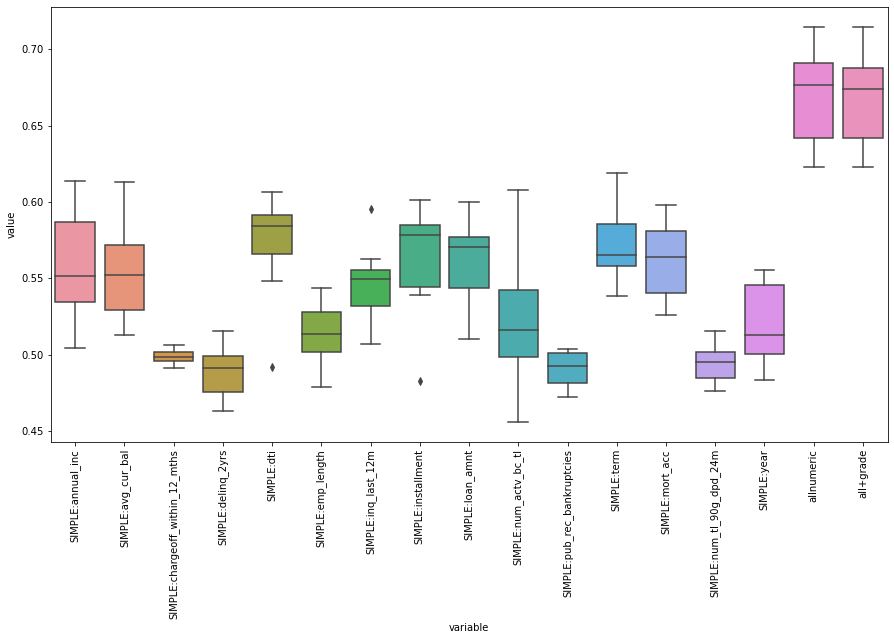

In [101]:
plt.figure(figsize=(15,8))
graf_caja3 = sns.boxplot(data = df4, x = 'variable', y = 'value')
graf_caja3.set_xticklabels(graf_caja3.get_xticklabels(),rotation = 90)

5. investigar si la variable categórica job aporta algún valor predictivo cuando se añade al mejor modelo actual.

In [102]:
job = data['job']
job_dummy = pd.get_dummies(job, columns=['job'])
allnumeric_job = pd.concat([allnumeric, job_dummy], axis = 1)
allnumeric_job

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,installment,loan_amnt,num_actv_bc_tl,...,technician,technologist,teller,therapist,trainer,underwriter,vp,warehouse,welder,worker
0,80000.0,6746.0,0.0,0.0,15.12,10,1.0,743.75,22800,1.0,...,0,0,0,0,0,0,0,0,0,0
1,60000.0,13623.0,0.0,0.0,12.32,7,0.0,286.73,10500,3.0,...,0,0,0,0,0,0,0,0,0,0
2,78000.0,11011.0,0.0,0.0,25.00,1,6.0,869.66,35000,4.0,...,0,0,0,0,0,0,0,0,0,0
3,62000.0,9679.0,0.0,0.0,22.32,9,7.0,713.96,20000,2.0,...,0,0,0,0,0,0,0,0,0,0
4,49000.0,4925.0,0.0,0.0,32.43,10,0.0,366.51,10000,4.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,90000.0,47759.0,0.0,0.0,15.88,3,3.0,49.46,1600,1.0,...,0,0,0,0,0,0,0,0,0,0
4996,43000.0,11702.0,0.0,0.0,14.09,10,1.0,155.51,5000,2.0,...,0,0,0,0,0,0,0,0,0,0
4997,70000.0,16495.0,0.0,0.0,24.02,1,0.0,250.66,8000,2.0,...,0,0,0,0,0,0,0,0,0,0
4998,50000.0,24012.0,0.0,0.0,17.33,4,1.0,69.38,2000,4.0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
model_perf4= model_perf3.copy()

In [109]:
model_perf4['allnumeric_job'] = cross_validation_AUC(allnumeric_job,y,k=10)

A:\Programar\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
A:\Programar\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [110]:
df5 = pd.melt(model_perf4)

[Text(0, 0, 'SIMPLE:annual_inc'),
 Text(1, 0, 'SIMPLE:avg_cur_bal'),
 Text(2, 0, 'SIMPLE:chargeoff_within_12_mths'),
 Text(3, 0, 'SIMPLE:delinq_2yrs'),
 Text(4, 0, 'SIMPLE:dti'),
 Text(5, 0, 'SIMPLE:emp_length'),
 Text(6, 0, 'SIMPLE:inq_last_12m'),
 Text(7, 0, 'SIMPLE:installment'),
 Text(8, 0, 'SIMPLE:loan_amnt'),
 Text(9, 0, 'SIMPLE:num_actv_bc_tl'),
 Text(10, 0, 'SIMPLE:pub_rec_bankruptcies'),
 Text(11, 0, 'SIMPLE:term'),
 Text(12, 0, 'SIMPLE:mort_acc'),
 Text(13, 0, 'SIMPLE:num_tl_90g_dpd_24m'),
 Text(14, 0, 'SIMPLE:year'),
 Text(15, 0, 'allnumeric'),
 Text(16, 0, 'all+grade'),
 Text(17, 0, 'allnumeric_job')]

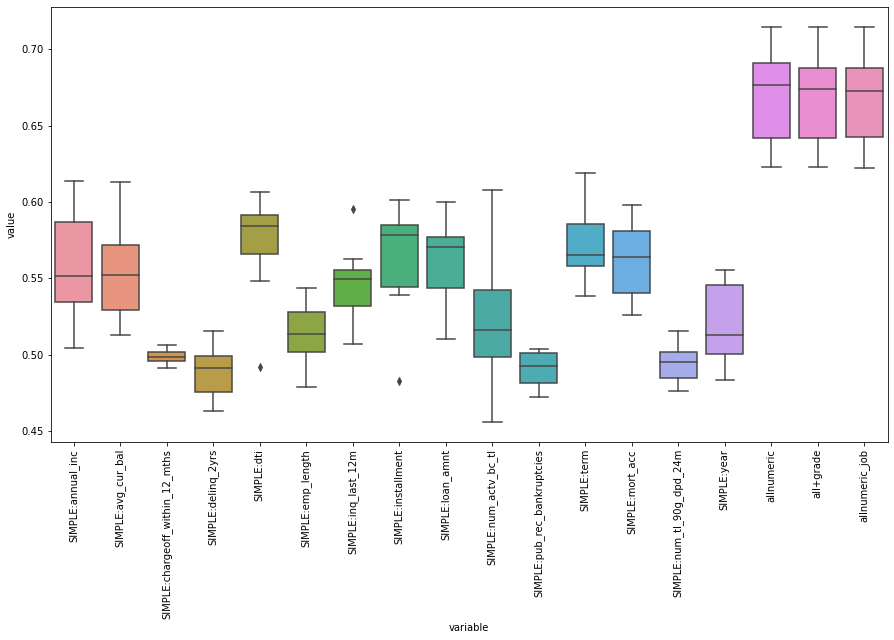

In [111]:
plt.figure(figsize=(15,8))
graf_caja4 = sns.boxplot(data = df5, x = 'variable', y = 'value')
graf_caja4.set_xticklabels(graf_caja4.get_xticklabels(),rotation = 90)

La validación cruzada es una técnica robusta y flexible para evaluar el rendimiento predictivo de los modelos estadísticos. Es especialmente útil en entornos de big data en los que el número de características es grande en comparación con el número de observaciones. Cuando se utiliza adecuadamente, la validación cruzada es un método poderoso para elegir un modelo con la complejidad correcta y el mejor rendimiento predictivo. Recuerde que la regresión logística es sólo uno de los muchos algoritmos de clasificación y que los principios en los que se basa la validación cruzada no se limitan sólo a este caso. De hecho, recomendamos encarecidamente utilizar la validación cruzada también para sus modelos de regresión lineal para evitar el overfitting.